<a href="https://colab.research.google.com/github/dbtronics/COMP551-Miniproject-1/blob/local_dt/Copy_of_DecisionTree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

-----
[[34.   1.   2.  ...  4.  75.   1. ]
 [39.   1.   1.  ...  4.4 85.   1. ]
 [32.   1.   2.  ...  3.7 54.   1. ]
 ...
 [31.   1.   1.  ...  4.2 54.   2. ]
 [53.   2.   1.  ...  4.1 48.   2. ]
 [43.   1.   2.  ...  3.1 42.   2. ]]
115
accuracy is 58.9.
accuracy is 90.4.
230
accuracy is 60.0.
accuracy is 85.2.
345
accuracy is 63.3.
accuracy is 81.7.
460
accuracy is 64.4.
accuracy is 80.9.
576
accuracy is 68.2.
accuracy is 79.5.
691
accuracy is 67.0.
accuracy is 79.5.
806
accuracy is 67.5.
accuracy is 79.5.
921
accuracy is 66.5.
accuracy is 78.6.
1036
accuracy is 65.2.
accuracy is 79.1.


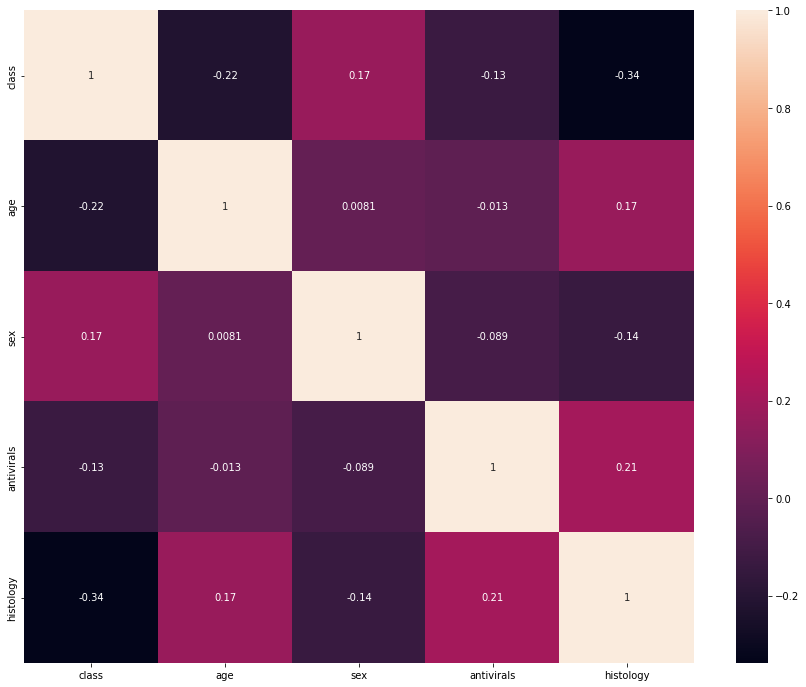

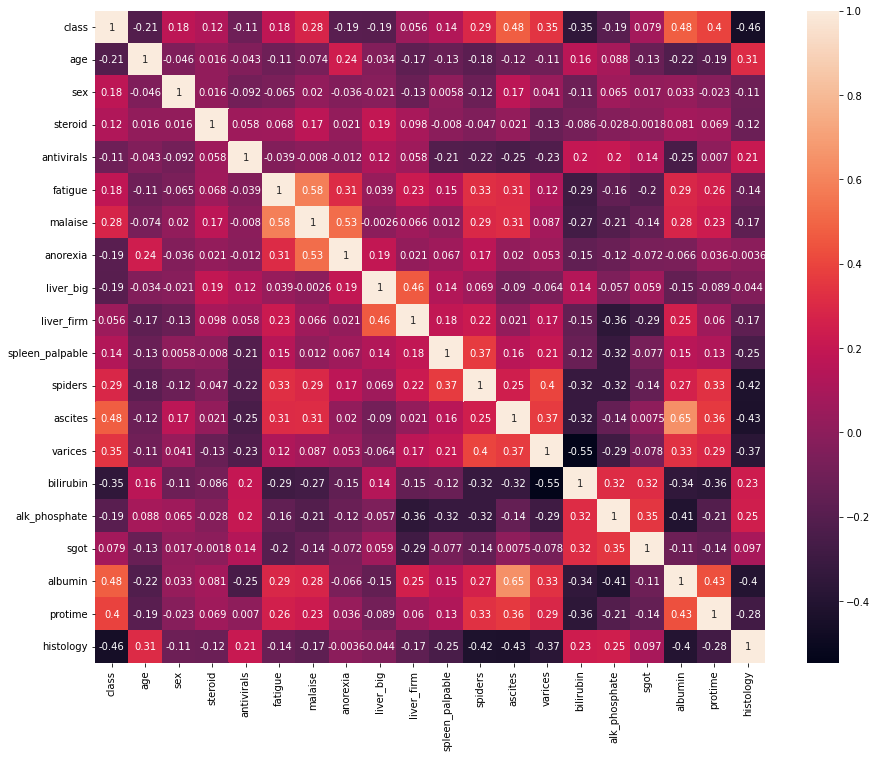

In [100]:
from IPython.core.display import set_matplotlib_formats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from cProfile import label
from scipy.io import arff
from scipy.stats import mode
np.random.seed(1234)

def task1():
    data3 = arff.loadarff('./sample_data/messidor_features.arff')
    data3 = pd.DataFrame(data3[0])
    col_names = ['qual_assess','pre_screen','MA_detection_.5','MA_detection_.6','MA_detection_.7','MA_detection_.8',
            'MA_detection_.9','MA_detection_1.0','exudate_detection_.3','exudate_detection_.4','exudate_detection_.5','exudate_detection_.6'
            ,'exudate_detection_.7','exudate_detection_.8','exudate_detection_.9','exudate_detection_1.0',
            'euc_dist','diam_opt_disc','AM/FM','class_label']
    data3.columns = col_names
    data3.class_label = data3.class_label.apply(lambda x: pd.to_numeric(str(x)[2]))
    data3 = data3.replace({'?' : np.nan}).dropna()
    
    # print(df.corr())
    # print(df)
    # basic statistics df
    # print(df.describe(include='all'))
    # Document messidor features.arff above
    # Document hepatitis below
    df2 = pd.read_csv('./sample_data/hepatitis1.csv', 
    names=["class", "age", "sex", "steroid", "antivirals", 
    "fatigue", "malaise", "anorexia", "liver_big", "liver_firm", 
    "spleen_palpable", "spiders", "ascites", "varices", "bilirubin", 
    "alk_phosphate", "sgot", "albumin", "protime", "histology"])
    df2 = df2.replace({'?': np.nan}).dropna()
    af = df2.select_dtypes(include="object")
    dic = {}
    for i in af:
      df2[i] = df2[i].astype(float, errors = "raise")
    df2.astype(dic).dtypes
    plt.figure(figsize = (15,12))
    corr = df2.corr()
    sns.heatmap(corr, annot = True)
    plt.savefig("data1.png",dpi=1200,transparent=True,bbox_inches = 'tight')
    # print(df2.corr())
    # print(df2)
    # basic statistics df2
    # print(df2.describe(include='all'))

    # data3 = data3.to_numpy()
    # df2 = df2.to_numpy()
    # print(df[:, 18:]) # taking values that are besides 1 and 0
    # print(df2[:, 16:]) # taking values that are besides 1 and 0
    return data3, df2 # messidor and hep data respectively

class Node:
    def __init__(self,indices,parent):
      self.indices = indices
      self.left = None
      self.right = None
      self.split_feature = None
      self.split_value = None
      if parent:
        self.depth = parent.depth+1
        self.num_classes = parent.num_classes
        self.data = parent.data
        self.labels = parent.labels
        class_probs = np.bincount(self.labels[indices],minlength = self.num_classes)
        self.class_probs = class_probs/np.sum(class_probs)

def greedy_test(node,cost_func):
    best_cost = np.inf
    best_feature, best_value = None, None
    num_instances,num_features = node.data.shape
    #sort the features to get the test value candidates 
    #taking avg of consecutive sorted feature values
    data_sorted = np.sort(node.data[node.indices],axis=0)
    test_candidates = (data_sorted[1:]+data_sorted[:-1])/2.
    for f in range(num_features):
      data_f = node.data[node.indices,f]
      for test in test_candidates[:,f]:
          # store the data corresponding to the f-th feature
          left_ind = node.indices[data_f <= test]
          right_ind = node.indices[data_f > test]
          # stop splitting when the child has zero element
          if len(left_ind)==0 or len(right_ind)==0:
              continue
          #compute the left and right cost based on the current split
          left_cost = cost_func(node.labels[left_ind])
          right_cost = cost_func(node.labels[right_ind])
          num_left, num_right = left_ind.shape[0], right_ind.shape[0]
          #the weighted sum of left and right cost
          cost = (num_left*left_cost+num_right*right_cost)/num_instances
          # updates the lowest cost
          if cost<best_cost:
              best_cost = cost
              best_feature = f
              best_value = test
    return best_cost,best_feature,best_value

def cost_misclassification(labels):
    #subtract the maximum prob of any class
    counts = np.bincount(labels)
    class_probs = counts/np.sum(counts)
    return 1-np.max(class_probs)

def cost_entropy(labels):
    #class probabilities
    class_probs = np.bincount(labels)/len(labels)
    class_probs = class_probs[class_probs>0]
    return -np.sum(class_probs*np.log(class_probs))

def cost_gini_index(labels):
    class_probs = np.bincount(labels)/len(labels)
    return 1-np.sum(np.square(class_probs))

class DecisionTree:
    def __init__(self,num_classes=None, max_depth=3,cost_func=cost_misclassification,min_leaf_instances=1):
        self.max_depth = max_depth
        self.root = None
        self.cost_func = cost_func
        self.num_classes = num_classes
        self.min_leaf_instances = min_leaf_instances
    def fit(self, data, labels):
        pass                            #pass in python 3 means nothing happens and the method here is empty
    
    def predict(self, data_test):
        pass
    
def fit(self,data,labels):
        self.data = data
        self.labels = labels
        if self.num_classes is None:
            self.num_classes = np.max(labels)+1
        # initialize the root
        self.root = Node(np.arange(data.shape[0]),None)
        self.root.data = data
        self.root.labels = labels
        self.root.num_classes = self.num_classes
        self.root.depth =0
        self._fit_tree(self.root)
        return self

def _fit_tree(self,node):
        # terminate consition : leaf node
        if node.depth == self.max_depth or len(node.indices) <= self.min_leaf_instances:
           return
        #greedy alg to select the best test by minimizing the cost
        cost,split_feature,split_value = greedy_test(node,self.cost_func)
        # inifinity means that not possible to split
        if np.isinf(cost):
          return
        test = node.data[node.indices,split_feature] <= split_value
        #store the split feature and value 
        node.split_feature = split_feature
        node.split_value = split_value

        left = Node(node.indices[test],node)
        right = Node(node.indices[np.logical_not(test)],node)
        #recursively call fit_tree function
        self._fit_tree(left)
        self._fit_tree(right)
        node.left = left
        node.right = right

DecisionTree.fit = fit
DecisionTree._fit_tree = _fit_tree

def predict(self,data_test):
        class_probs = np.zeros((data_test.shape[0],self.num_classes))
        for n,x in enumerate(data_test):
          node = self.root
          #loop along the depth of the tree where the parent data sample fall in 
          #based on the split
          while node.left:
            if x[node.split_feature] <= node.split_value:
                node = node.left
            else:
                node = node.right
          class_probs[n,:] = node.class_probs
        return class_probs


# -----------------
# Main code below
# -----------------


def evaluate_acc(self,y_test,y_pred,x_test,x_train):
    accuracy = np.sum(y_pred == y_test)/y_test.shape[0]
    print(f'accuracy is {accuracy*100:.1f}.')
    # return accuracy
    # correct = y_test == y_pred
    # incorrect = np.logical_not(correct)
    # plt.scatter(x_train[:,0], x_train[:,1], c=y_train, marker='o', alpha=.2, label='train')
    # plt.scatter(x_test[correct,0], x_test[correct,1], marker='.', c=y_pred[correct], label='correct')
    # plt.scatter(x_test[incorrect,0], x_test[incorrect,1], marker='x', c=y_test[incorrect], label='misclassified')
    # plt.legend()
    # plt.show()




from sklearn import datasets

DecisionTree.predict = predict


mess_data, hep_data = task1()  # get two datasets
    
# mess_data = mess_data.astype(np.float64)
# hep_data = hep_data.astype(np.float64)


# ----------------- data process ----------------------

# x = mess_data.loc[:,"MA_detection_.5":"MA_detection_.6"]
# print(x)


x_2 = hep_data.drop("class",axis = 1).values
print("-----")
print(x_2)
x = mess_data.drop("class_label",axis = 1).values

# looks like below
# [[ 1.        1.       22.       ...  0.486903  0.100025  1.      ]
#  [ 1.        1.       24.       ...  0.520908  0.144414  0.      ]
#  [ 1.        1.       62.       ...  0.530904  0.128548  0.      ]
#  ...
#  [ 1.        0.       49.       ...  0.560632  0.129843  0.      ]
#  [ 1.        1.       39.       ...  0.485972  0.10669   1.      ]
#  [ 1.        1.        7.       ...  0.556192  0.088957  0.      ]]
x = x[:, [2,3]]
# [[22. 22.]
#  [24. 24.]
#  [62. 60.]
#  ...
#  [49. 48.]
#  [39. 36.]
#  [ 7.  7.]]
y = mess_data['class_label'].values
# [0 0 1 ... 0 1 0]
for i in range(1,10):
  train_portion = i/10


  num_classes = 2

  num_of_instances = x.shape[0]
  num_of_features = x.shape[1]

  num_train_portion = round(train_portion * num_of_instances)
  print(num_train_portion)
  shuffle = np.random.RandomState(seed = 1234).permutation(num_of_instances) 
  # Mix all the instances by random to better train the datasets
  # Now split the datasets to train
  x_train, y_train, x_test, y_test = x[shuffle[:num_train_portion]], y[shuffle[:num_train_portion]], x[shuffle[num_train_portion:]], y[shuffle[num_train_portion:]]
  # Now the datasets has been splited
  # below initialize tree object
  tree = DecisionTree(max_depth = 20)
  # Accuracy with test set
  test = tree.fit(x_train, y_train).predict(x_test)
  y_pred = np.argmax(test,1)
  evaluate_acc(tree, y_test,y_pred,x_test,x_train)
  # Accuracy with train set
  test = tree.fit(x_train, y_train).predict(x_train)
  y_pred = np.argmax(test,1)
  evaluate_acc(tree, y_train,y_pred,x_test,x_train)








# hepatitis dataset
# for i in range(1, max_depth):
#   print("depth = ", i)
#   tree = DecisionTree(max_depth=i)
#   probs_test = tree.fit(hep_x_train,hep_y_train).predict(hep_x_test)
#   y_pred = np.argmax(probs_test,1)
#   accuracy = np.sum(y_pred == hep_y_test)/hep_y_test.shape[0]
#   print(f'accuracy is {accuracy*100:.1f}.')
#   # print("Messidore Accuracy: ", task2(i, mess_x_train, mess_y_train, mess_x_test))
#   #print("Hepatitis Accuracy: ", decisionTreeTask(i, hep_x_train, hep_y_train, hep_x_test))
#   print("\n")
# dataset = datasets.load_iris()
# x,y = dataset['data'][:,:2],dataset['target']
# (num_instances,num_features), num_classes=x.shape, np.max(y)+1
# inds = np.random.permutation(num_instances)
# x_train,y_train = x[inds[:100]],y[inds[:100]]
# x_test,y_test = x[inds[100:]],y[inds[100:]]

# tree = DecisionTree(max_depth=20)
# probs_test = tree.fit(x_train,y_train).predict(x_test)
# y_pred = np.argmax(probs_test,1)
# accuracy = np.sum(y_pred == y_test)/y_test.shape[0]
# print(f'accuracy is {accuracy*100:.1f}.')